# 프로젝트 E-8

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 일단 데이터부터 다시 살펴보자

In [2]:
data_folder_path = '/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data'

In [3]:
csv_file_path = os.getenv('HOME')+data_folder_path
train_path = join(csv_file_path,'train.csv')
test_path = join(csv_file_path,'test.csv')

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(train.shape)
print(train.columns)
train.head()

(15035, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
print(test.shape)
test.head()

(6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [5]:
y = train['price']
del train['price']


In [6]:
print(train.columns)
len(train.columns)
train.head()

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
train_len = len(train)
df = pd.concat((train, test), axis=0)

print(len(df))

21503


In [8]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 결측치 확인

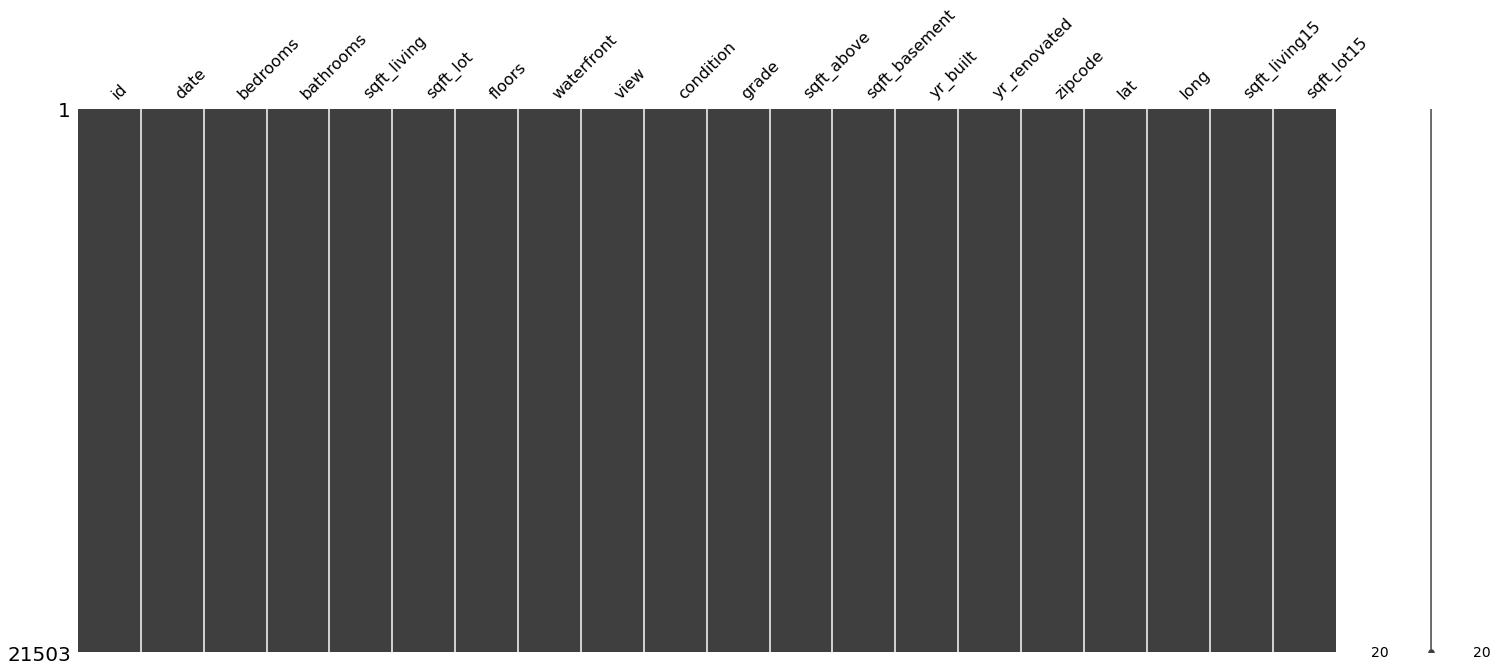

In [9]:
# 결측치 확인
msno.matrix(df)

In [10]:
# test set 의 id 를 test_id 변수에 저장하고 전체 데이터프레임에서 id 컬럼 제거.
test_id = df['id'][train_len:]
del df['id']

print(df.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [11]:
# 날짜 값을 int 타입으로 변환
df['date'] = df['date'].apply(lambda x : str(x[:6])).astype(int)

df.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 로그변환 전 데이터 분포

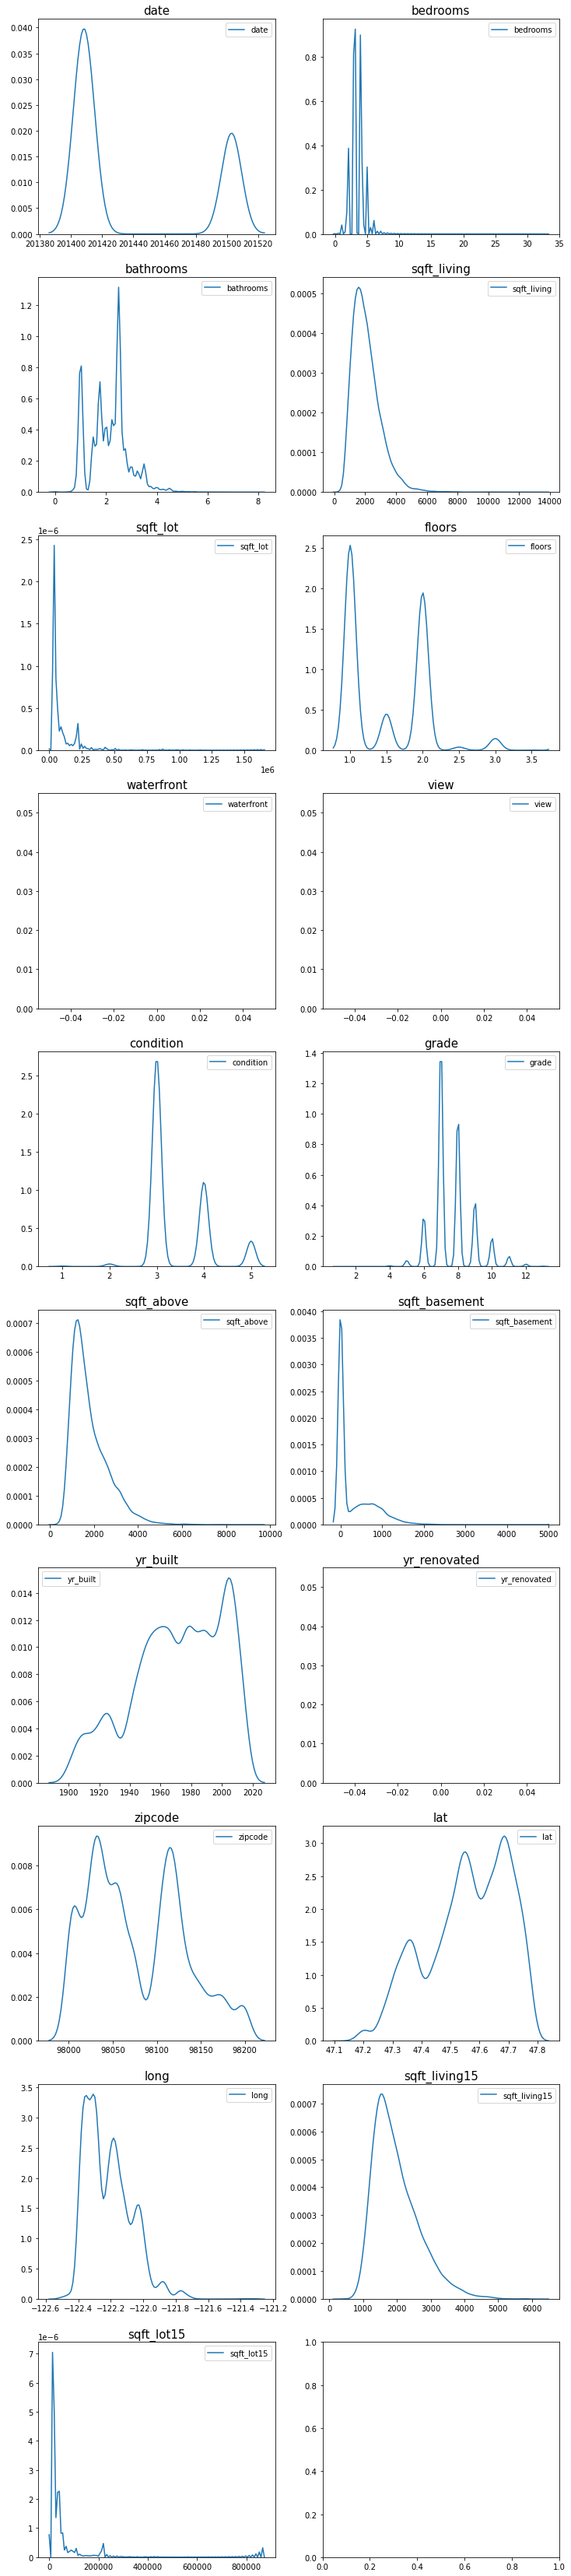

In [12]:
fig, ax = plt.subplots(10, 2, figsize=(12, 60))

count = 0
columns = df.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

### 로그변환

In [13]:
# bathrooms, sqft_living15,sqft_lot15 추가해봄
skew_columns = ['bedrooms','bathrooms', 'sqft_living','sqft_living15','sqft_lot','sqft_lot15', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df[c] = np.log1p(df[c].values)

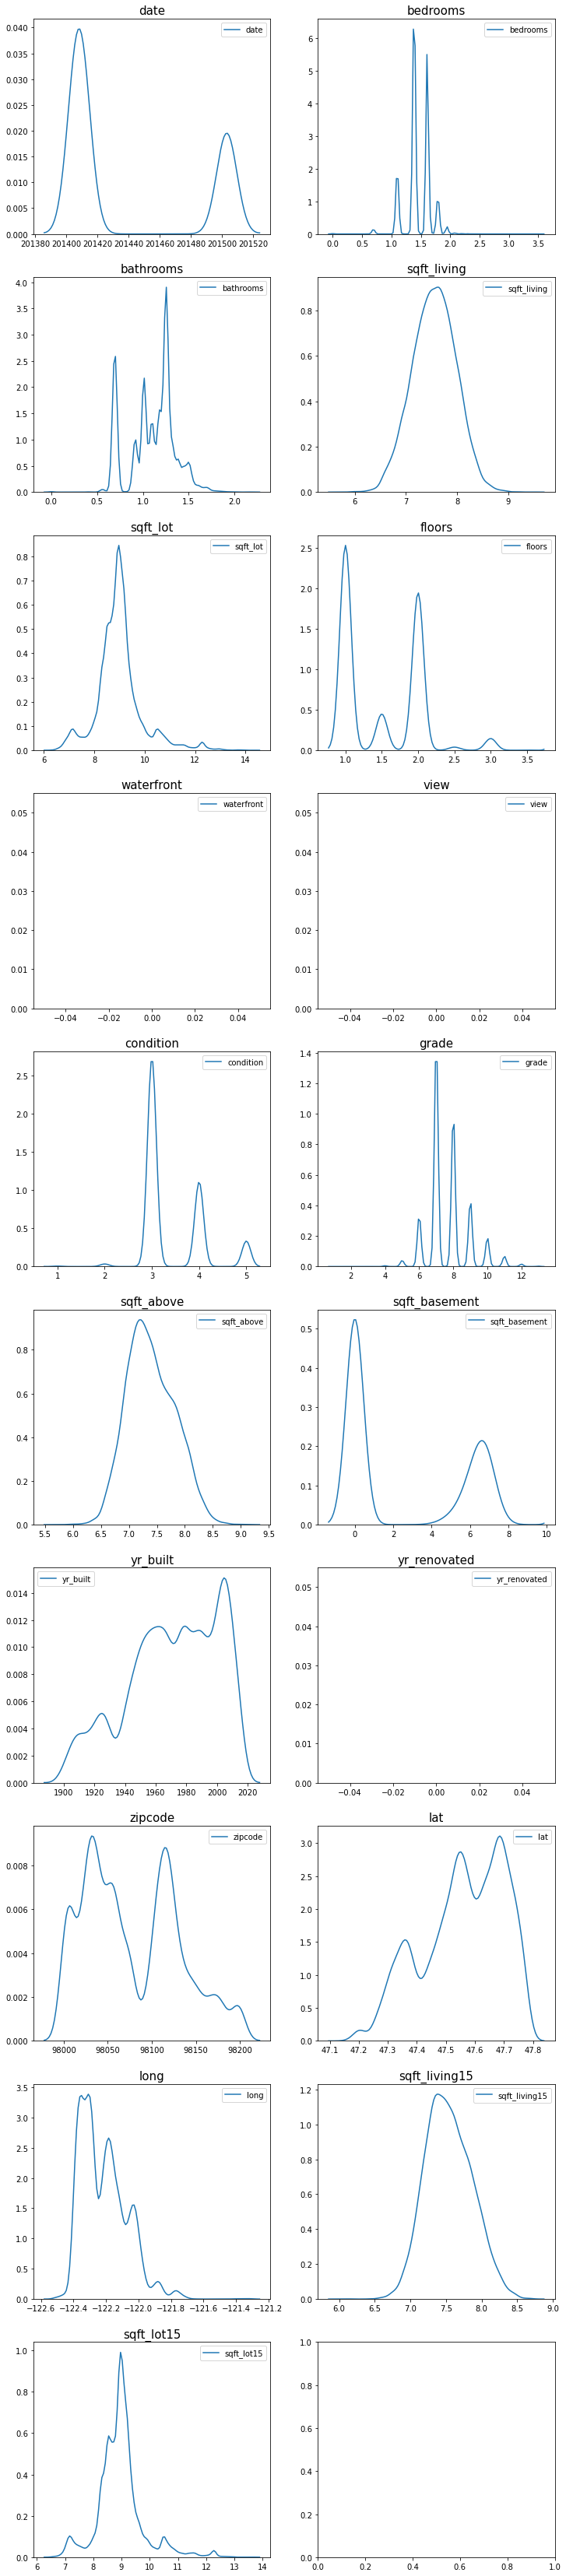

In [14]:
fig, ax = plt.subplots(10, 2, figsize=(12, 60))
# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = df.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

원래 y(price) 분포

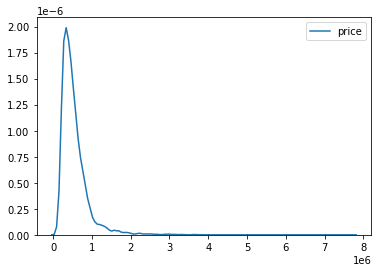

In [15]:
sns.kdeplot(y)
plt.show()

로그변환 후 분포

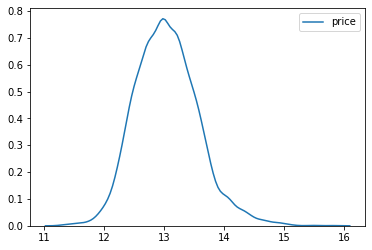

In [16]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [17]:
print(df.shape)
test = df.iloc[train_len:, :]
x = df.iloc[:train_len, :]

print(x.shape)
print(test.shape)

(21503, 19)
(15035, 19)
(6468, 19)


# 베이스라인 따라가기 복습

In [18]:
gboost = GradientBoostingRegressor(random_state=2020)
xgboost = xgb.XGBRegressor(random_state=2020)
lightgbm = lgb.LGBMRegressor(random_state=2020)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### 교차검증을 통한 모델 성능 평가

In [19]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [20]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8797
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025


### AveragingBlending 예시

In [21]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [22]:
y_pred = AveragingBlending(models, x, y, test)
print(len(y_pred))
y_pred

6468


array([13.14462881, 12.98192758, 14.08443622, ..., 13.02622152,
       12.72060769, 12.98918701])

### 제출용 파일 만들기

In [23]:
data_dir = os.getenv('HOME')+ data_folder_path

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [24]:
result = pd.DataFrame({
    'id' : test_id, 
    'price' : np.expm1(y_pred)
})

result.head()

,id,price
0,15035,5.112566e+05
1,15036,4.344887e+05
2,15037,1.308557e+06
3,15038,3.100471e+05
4,15039,3.184588e+05


In [25]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel0042/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data/submission.csv


# 이제 내가 변경해보자

### RMSE 계산함수

In [29]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [30]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [31]:
np.any(np.isnan(x))

False

In [32]:
np.all(np.isfinite(x))

True

In [33]:
def get_scores(models, train, y):
  df = {}
  for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
  return score_df

get_scores(models, x, y)

,RMSE
GradientBoostingRegressor,128370.486911
RandomForestRegressor,125303.558748
LGBMRegressor,111906.268088
XGBRegressor,110319.692215


In [36]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
  # 1. GridSearchCV 모델로 `model`을 초기화합니다.
  grid_model = GridSearchCV(model, param_grid=param_grid, \
                          scoring='neg_mean_squared_error', \
                          cv=5,verbose=verbose, n_jobs=n_jobs)
  # 2. 모델을 fitting 합니다.
  grid_model.fit(train, y)
  
  # 3. params, score에 각 조합에 대한 결과를 저장합니다. 
  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']
  
  # 4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
  results = pd.DataFrame(params)
  results['score'] = score
  
  results['RMSLE'] = np.sqrt(-1 * results['score'])
  results.sort_values('RMSLE',inplace=True)

  return results

In [38]:
learning_rates = [0.01,0.1]
max_depth = [5,7,10]
n_estimators = [300,400,500]

# LGBM_param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'learning_rate' : learning_rates
# }

# XGB_param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'n_estimators': n_estimators,
#               'max_depth': max_depth,
#               'learning_rate' : learning_rates,                              
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               }

# # GradientBoostingRegressor
# GBR_param_grid={
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'learning_rate' : learning_rates,
    # 'min_samples_leaf':[3,5,9,17]
    # 'max_features':[0.1,0.5,1.0]
#     }
# #  , 
  
# RandomForestRegressor = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'learning_rate' : learning_rates
# }

# 사실상 다들 비슷비슷해서... common으로 다 grid search 진행
common_param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate' : learning_rates
}
# RandomForestRegressor 빼고!
RFR_param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
}

LGBM_param_grid = {
    'n_estimators': [400],
    'max_depth': [7,8,9,10],
    'learning_rate' : [0.1],
}

### 4개 모델에 대해 common_param_grid 로 설정한 값으로 grid search 해보자
그리고 가장 좋은 결과로 저장.

In [41]:
models = [GradientBoostingRegressor,XGBRegressor,RandomForestRegressor,LGBMRegressor]
searched_models = []
RMSLE_list = []

def get_searched_model(model):
    m = model(random_state=random_state)
    results = pd.DataFrame()
    if m.__class__.__name__ == 'RandomForestRegressor':
        results = my_GridSearch(m, x, y, RFR_param_grid, verbose=2, n_jobs=10)
    elif m.__class__.__name__ == 'LGBMRegressor':
        results = my_GridSearch(m, x, y, LGBM_param_grid, verbose=2, n_jobs=10)
    else : 
        results = my_GridSearch(m, x, y, common_param_grid, verbose=2, n_jobs=10)
    
    learning_rate = 0.0 
    if m.__class__.__name__ != 'RandomForestRegressor':
        learning_rate = results.loc[results.index[0],:]['learning_rate']
        
    max_depth = results.loc[results.index[0],:]['max_depth']
    n_estimators = results.loc[results.index[0],:]['n_estimators']
    RMSLE = results.loc[results.index[0],:]['RMSLE']
    
    # num_leaves = 0
    # if m.__class__.__name__ == 'LGBMRegressor':
    #     num_leaves = results.loc[results.index[0],:]['num_leaves']
    #     print(m.__class__.__name__,learning_rate, max_depth,n_estimators,num_leaves,RMSLE)
    # else:
    print(m.__class__.__name__,learning_rate, max_depth,n_estimators,RMSLE)
    
    RMSLE_list.append(RMSLE)

    if m.__class__.__name__ != 'RandomForestRegressor':
        searched_models.append(        
                model(learning_rate = learning_rate, max_depth=int(max_depth), n_estimators=int(n_estimators), random_state=random_state)        
        )
    else :
        searched_models.append(        
                model(max_depth=int(max_depth), n_estimators=int(n_estimators), random_state=random_state)        
        )

원래 for loop 으로 4가지 모델에 대해 그리드 서치를 한 번에 진행했는데...그렇게 하면 너무 오래걸려서 나눠서 해봄

In [42]:
# GradientBoostingRegressor
get_searched_model(models[0])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   45.4s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:  3.4min finished
GradientBoostingRegressor 0.1 5.0 400.0 0.16342982728620098


In [43]:
# XGBRegressor
get_searched_model(models[1])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   58.4s finished
XGBRegressor 0.1 5.0 500.0 0.16185670954518386


In [44]:
# RandomForestRegressor
get_searched_model(models[2])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   32.3s
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:  1.2min finished
RandomForestRegressor 0.0 10.0 500.0 0.18682730094715183


In [45]:
# LGBMRegressor
get_searched_model(models[3])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    2.3s finished
LGBMRegressor 0.1 10.0 400.0 0.16160911047917967


In [139]:
## 'sqft_living15' 로그변환 전 

# RMSLE_list = [0.16338798727353093,0.1618570842091542, 0.18683927506650622 ,0.16160911047917967]
# print(RMSLE_list)
# searched_models = [
#     GradientBoostingRegressor(learning_rate =0.1, max_depth= 5, n_estimators=400),
#     XGBRegressor(learning_rate =0.1, max_depth= 5, n_estimators=500),
#     RandomForestRegressor(max_depth= 10, n_estimators=500),
#     LGBMRegressor(learning_rate =0.1, max_depth= 10, n_estimators=400)
# ]
# searched_models

# [0.16338798727353093, 0.1618570842091542, 0.18683927506650622, 0.16160911047917967]
# [GradientBoostingRegressor(max_depth=5, n_estimators=400),
#  XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
#               colsample_bynode=None, colsample_bytree=None, gamma=None,
#               gpu_id=None, importance_type='gain', interaction_constraints=None,
#               learning_rate=0.1, max_delta_step=None, max_depth=5,
#               min_child_weight=None, missing=nan, monotone_constraints=None,
#               n_estimators=500, n_jobs=None, num_parallel_tree=None,
#               random_state=None, reg_alpha=None, reg_lambda=None,
#               scale_pos_weight=None, subsample=None, tree_method=None,
#               validate_parameters=None, verbosity=None),
#  RandomForestRegressor(max_depth=10, n_estimators=500),
#  LGBMRegressor(max_depth=10, n_estimators=400)]

[0.16338798727353093, 0.1618570842091542, 0.18683927506650622, 0.16160911047917967]


[GradientBoostingRegressor(max_depth=5, n_estimators=400),
 XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 RandomForestRegressor(max_depth=10, n_estimators=500),
 LGBMRegressor(max_depth=10, n_estimators=400)]

In [47]:
## 'sqft_living15' 로그변환 후

print(RMSLE_list)
print(searched_models)

[0.16342982728620098, 0.16185670954518386, 0.18682730094715183, 0.16160911047917967]
[GradientBoostingRegressor(max_depth=5, n_estimators=400, random_state=2020), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), RandomForestRegressor(max_depth=10, n_estimators=500, random_state=2020), LGBMRegressor(max_depth=10, n_estimators=400, random_state=2020)]


### RMSLE 가 가장 낮게 나온 모델을 이용한 제출파일

In [49]:
def save_submission_each_model(model, train, y, test, model_name, rmsle):
  # 1. 모델을 `train`, `y`로 학습시킵니다.
  model.fit(train, y)
  # 2. `test`에 대해 예측합니다.
  prediction = model.predict(test)
  # 3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
  prediction = np.expm1(prediction)
  
  data_dir = os.getenv('HOME')+data_folder_path

  submission_path = join(data_dir, 'sample_submission.csv')
  submission = pd.read_csv(submission_path)
  
  submission['price'] = prediction
  
  submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name , rmsle)
  submission.to_csv(submission_csv_path, index=False)
  print('{} saved!'.format(submission_csv_path))

In [88]:
## 'sqft_living15' 로그변환 전 

# RMSLE 가 가장 낮게 나온 모델에 대해 submission 파일 만들어보기
# 가장 낮게 나온 모델 :  LGBMRegressor(learning_rate =0.1, max_depth= 10, n_estimators=400)

# model_idx = 3
# model = searched_models[model_idx]
# save_submission_each_model(model, x, y, test, model.__class__.__name__, rmsle=RMSLE_list[model_idx])

/home/aiffel0042/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data/submission_LGBMRegressor_RMSLE_0.16127325801394868.csv saved!


In [50]:
## 'sqft_living15' 로그변환 후

# RMSLE 가 가장 낮게 나온 모델에 대해 submission 파일 만들어보기
# 가장 낮게 나온 모델 :  LGBMRegressor(max_depth=10, n_estimators=400, random_state=2020)

model_idx = 3
model = searched_models[model_idx]
save_submission_each_model(model, x, y, test, model.__class__.__name__, rmsle=RMSLE_list[model_idx])

/home/aiffel0042/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data/submission_LGBMRegressor_RMSLE_0.16160911047917967.csv saved!


In [51]:
## 'sqft_living15' 로그변환 후

# RMSLE 가 두번째로 낮게 나온 모델에 대해 submission 파일 만들어보기
# 두번째로 낮게 나온 모델 :  XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
            #  colsample_bynode=None, colsample_bytree=None, gamma=None,
            #  gpu_id=None, importance_type='gain', interaction_constraints=None,
            #  learning_rate=0.1, max_delta_step=None, max_depth=5,
            #  min_child_weight=None, missing=nan, monotone_constraints=None,
            #  n_estimators=500, n_jobs=None, num_parallel_tree=None,
            #  random_state=2020, reg_alpha=None, reg_lambda=None,
            #  scale_pos_weight=None, subsample=None, tree_method=None,
            #  validate_parameters=None, verbosity=None)

model_idx = 1
model = searched_models[model_idx]
save_submission_each_model(model, x, y, test, model.__class__.__name__, rmsle=RMSLE_list[model_idx])

/home/aiffel0042/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data/submission_XGBRegressor_RMSLE_0.16185670954518386.csv saved!


### 'sqft_living15' 로그변환 전 제출결과
LGBMRegressor(learning_rate =0.1, max_depth= 10, n_estimators=400) 을 제출했더니 나온 점수   
110376.07924 (private)   
LGBMRegressor(learning_rate =0.1, max_depth= 10, n_estimators=400, num_leaves=15) 을 제출했더니 나온 점수   
113470.74620 (private)   
=> num_leaves 값으로 인해 과적합이 발생하는 것으로 보인다!

### 'sqft_living15' 로그변환 후 제출결과
1. LGBMRegressor(max_depth=10, n_estimators=400, random_state=2020)      
110376.07924 (private)
2. XGBRegressor (lr = 0.1 max_depth = 5 n_esti = 500)    
110860.08986 (private)

### 이제 4개의 결과를 앙상블해서 결과를 내보자
일단 처음에는 baseline 에 등장한 averaging blending

In [52]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    
    return np.mean(predictions, axis=1)

In [53]:
def save_submission_all_modesl(models, train, y, test, model_name='ensemble'):

    prediction = AveragingBlending(models, train, y, test)
    print('before transform',prediction)

    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+data_folder_path

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)

    submission['price'] = prediction

    submission_csv_path = '{}/submission_{}.csv'.format(data_dir, model_name)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [90]:
## 'sqft_living15' 로그변환 전 

# 전체 모델에 대해 앙상블 만들어보기

save_submission_all_modesl(searched_models, x, y, test,'ensemble')

before transform [13.12163696 13.06179247 14.14787215 ... 13.06316294 12.72813934
 13.00243317]
/home/aiffel0042/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data/submission_ensemble.csv saved!


### 'sqft_living15' 로그변환 전 

1차 ensemble 해서 나온 점수 : 113019.33335 (private)  
2차 ensemble 해서 나온 점수 : 113396.71619 (private)     

In [55]:
## 'sqft_living15' 로그변환 후

save_submission_all_modesl(searched_models, x, y, test,'ensemble_extra_log')


before transform [13.14071399 13.06539746 14.13144885 ... 13.05176379 12.73770445
 13.00476837]
/home/aiffel0042/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data/submission_ensemble_extra_log.csv saved!


### 'sqft_living15' 로그변환 후
1차 ensemble 해서 나온 점수 : 112893.56293 (private)   

In [58]:
## 'sqft_living15' 로그변환 후
# lgbm 과 xgb 만 ensemble 해보기
temp_models = [searched_models[1],searched_models[3]]
save_submission_all_modesl(temp_models, x, y, test,'ensemble_lgbm_xgb')


before transform [13.16584726 13.05370316 14.13292812 ... 13.05770552 12.71449246
 13.01602051]
/home/aiffel0042/Desktop/2020_aiffel/daily_notes/exploration_codes/e8_code/data/submission_ensemble_lgbm_xgb.csv saved!


### 'sqft_living15' 로그변환 후
lgbm 과 xgb 만 ensemble 해보기   
1차 ensemble 해서 나온 점수 : 108628.19638 (private)   

# 결과 보고서

## 최종 결과 private score 기준 108628.19638

LGBM, XGB 두 가지를 ensemble 하여 만들어낸 결과물이 가장 좋았다. 

### 각각을 제출했을 때의 점수
1. LGBMRegressor(max_depth=10, n_estimators=400, random_state=2020)      
110376.07924 (private)
2. XGBRegressor (lr = 0.1 max_depth = 5 n_esti = 500)    
110860.08986 (private)

### 두 가지를 ensemble 하여 제출했을 때의 점수 
108628.19638 (private)
108660.62132 (public)

## 시행착오

1. lms 에서 로그 변환한 컬럼 이외에 bathrooms, sqft_lot15 두 가지 값을 추가로 로그 변환하여 진행
2-0. grid search 를 이용하여 다양한 하이퍼파라미터 조정을 해봄. 최적을 찾음.
2-1. lgbm 을 활용하여 11만 300점 가량까지 낮춰짐.
2-2. 4개의 모델을 ensemble 해봄. 오히려 점수가 더 나빠짐.
2-3. 다른 방법을 고민하기 시작.
3. sqft_living15 컬럼의 분포도 로그 변환을 하면 좋을 것 같다는 생각이 들어서 변환.
4. xgb 가 cross validation 테스트에서 좋은 결과를 보여주어서, 신경쓰기 시작.
5. xgb, lgbm 을 각각 학습하여 제출해봄
6. 결과는 아직 11만 300점이 최선
7. 4개를 다 ensemble해봄. 역시나 2-2 때와 마찬가지로 점수가 더 나빠짐.
8. 4개 중 제일 잘하는 두 개만 뽑아서 ensemble 해보면 어떨까 싶은 생각이 들었음.
9. 그렇게 해봤더니 11만점 이하의 108628.19638 점을 받을 수 있었음.

## 생각

하이퍼파라미터 탐색과정이 생각보다 만만치 않음을 알게 되었다.
다음번에는 random search 를 사용해보는 것도 고려해봐야겠다.
ensemble 의 조합도 다양하게 생각해보는 것이 좋을 수 있겠다는 생각이 들었다.